<!-- Banner Image -->
<img src="https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brev-xmas-3.png" width="100%">

<!-- Links -->
<center>
  <a href="https://console.brev.dev" style="color: #06b6d4;">Console</a> •
  <a href="https://brev.dev" style="color: #06b6d4;">Docs</a> •
  <a href="/" style="color: #06b6d4;">Templates</a> •
  <a href="https://discord.gg/NVDyv7TUgJ" style="color: #06b6d4;">Discord</a>
</center>

# Fine-tuning Mixtral 8x7B using QLoRA 🤙

Welcome!

In this notebook and tutorial, we will fine-tune the [Mixtral 8x7B](https://huggingface.co/mistralai/Mixtral-8x7B-v0.1) Mixture of Experts (MoE) model, which outperforms Llama 2 70B on most tested benchmarks.

**Watch an accompanying video walk-through (but for Mistral 7B) [here](https://youtu.be/kmkcNVvEz-k?si=Ogt1wRFNqYI6zXfw&t=1)!** If you'd like to see that notebook instead, click [here](https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb).

[![](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/youtubebadge.svg)](https://www.youtube.com/watch?v=kmkcNVvEz-k&t=1s)

This tutorial will use QLoRA, a fine-tuning method that combines quantization and LoRA. For more information about what those are and how they work, see [this post](https://brev.dev/blog/how-qlora-works).

In this notebook, we will load the large model in 4bit using `bitsandbytes` and use LoRA to train using the PEFT library from Hugging Face 🤗.

Note that if you ever have trouble importing something from Huggingface, you may need to run `huggingface-cli login` in a shell. To open a shell in Jupyter Lab, click on 'Launcher' (or the '+' if it's not there) next to the notebook tab at the top of the screen. Under "Other", click "Terminal" and then run the command.

### Help us make this tutorial better! Please provide feedback on the [Discord channel](https://discord.gg/y9428NwTh3) or on [X](https://x.com/harperscarroll).

#### Before we begin: A note on OOM errors

If you get an error like this: `OutOfMemoryError: CUDA out of memory`, tweak your parameters to make the model less computationally intensive. I will help guide you through that in this guide, and if you have any additional questions you can reach out on the [Discord channel](https://discord.gg/y9428NwTh3) or on [X](https://x.com/harperscarroll).

To re-try after you tweak your parameters, open a Terminal ('Launcher' or '+' in the nav bar above -> Other -> Terminal) and run the command `nvidia-smi`. Then find the process ID `PID` under `Processes` and run the command `kill [PID]`. You will need to re-start your notebook from the beginning. (There may be a better way to do this... if so please do let me know!)

## Let's begin!
### 0. Preparing data

Before you check out a GPU, prepare your dataset for loading and training.

To prepare your dataset for loading, all you need are two `.jsonl` files structured something like this:
```
{"input": "What color is the sky?", "output": "The sky is blue."}
{"input": "Where is the best place to get cloud GPUs?", "output": "Brev.dev"}
```
If you choose to model your data as input/output pairs, you'll want to use something like the second `formatting_func` below, which will will combine all your features into one input string.

As you can see below, I have `notes.jsonl` for my `train_dataset` and `notes_validation.jsonl` for my `eval_dataset`.

I used Exporter, a free local-only app, to export my Apple Notes to `.txt` files, and then I wrote a script to process each note into one `.jsonl` file. Note that for this script, ChatGPT can help out a LOT if you tell it how your data is currently formatted, how you'd like it to be formatted, and ask it to write a script in a certain language you know well (for any debugging) to do so. I also broke up my journal entries so the training sample vector length was smaller (see the discussion on `max_length` and the data visualization below). I broke it into pieces so that contexts were encapsulated entirely, since I did want the model to understand context about my life. My data were ultimately formatted as:

```json
{"note": "journal-entry-for-model-to-predict"}
{"note": "journal-entry-for-model-to-predict-1"}
{"note": "journal-entry-for-model-to-predict-2"}
```

### 1. Instantiate GPU & Load Dataset

I used a GPU and dev environment from [brev.dev](https://brev.dev). Click the badge below to get your preconfigured instance:

[![](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://console.brev.dev/environment/new?instance=T4:g4dn.12xlarge&diskStorage=512&name=mixtral-finetune-own-data&file=https://github.com/brevdev/notebooks/raw/main/mixtral-finetune-own-data.ipynb&python=3.10&cuda=12.0.1)

A 4xT4 (as linked) with 16 GPU Memory per GPU was enough for me. At the time of writing this, it costs $3.91/hour, and it trained for about 4 hours for 300 training steps. You may need more GPUs and/or Memory if your sequence max_length is larger than 512.

Once you've checked out your machine and landed in your instance page, select the specs you'd like (I used **Python 3.10 and CUDA 12.0.1**; these should be preconfigured for you if you use the badge above) and click the "Build" button to build your verb container. Give this a few minutes.

A few minutes after your model has started Running, click the 'Notebook' button on the top right of your screen once it illuminates (you may need to refresh the screen). You will be taken to a Jupyter Lab environment, where you can upload this Notebook.


Note: You can connect your cloud credits (AWS or GCP) by clicking "Org: " on the top right, and in the panel that slides over, click "Connect AWS" or "Connect GCP" under "Connect your cloud" and follow the instructions linked to attach your credentials.

#### Install the necessary packages

In [1]:
!pip install bitsandbytes
!pip install transformers
!pip install peft
!pip install accelerate
!pip install datasets scipy ipywidgets matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.0 MB/s eta 0:00:00


#### Weights & Biases for tracking metrics

Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
# !pip install -q wandb -U

# import wandb, os
# wandb.login()

# wandb_project = "viggo-finetune"
# if len(wandb_project) > 0:
#     os.environ["WANDB_PROJECT"] = wandb_project

#### Load the dataset

In [4]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='rimworld_training_colab.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='rimworld_validation_colab.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

#### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [5]:
def formatting_func(example):
    text = f"### The following is a note by Eevee the Dog: {example['note']}"
    return text

Here's another common one:

```python
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text
```

In [7]:
# Colab Direct Conversion Script
# Copy and paste this entire code block into a Colab cell and run it

import json

def convert_to_notes_format(input_filename, output_filename):
    """Convert RimWorld JSONL files to the 'note' format expected by the Colab notebook."""
    converted_count = 0
    error_count = 0

    with open(input_filename, 'r') as infile, open(output_filename, 'w') as outfile:
        for line_num, line in enumerate(infile, 1):
            try:
                # Parse the JSON line
                data = json.loads(line.strip())

                # Extract input and output
                input_text = data.get('input', '').strip()
                output_text = data.get('output', '').strip()

                # Skip empty entries
                if not input_text or not output_text:
                    continue

                # Create note format
                note_content = f"Question: {input_text}\nAnswer: {output_text}"

                # Write to output file
                outfile.write(json.dumps({"note": note_content}) + '\n')
                converted_count += 1

            except json.JSONDecodeError as e:
                print(f"JSON decode error on line {line_num}: {e}")
                error_count += 1
            except Exception as e:
                print(f"Error processing line {line_num}: {e}")
                error_count += 1

    print(f"Conversion Summary for {input_filename}:")
    print(f"  Converted entries: {converted_count}")
    print(f"  Errors: {error_count}")

# Convert your files (make sure they're uploaded to Colab first)
convert_to_notes_format('rimworld_training_colab.jsonl', 'notes.jsonl')
convert_to_notes_format('rimworld_validation_colab.jsonl', 'notes_validation.jsonl')

# After running this, you can use the standard Colab code:
# train_dataset = load_dataset('json', data_files='notes.jsonl', split='train')
# eval_dataset = load_dataset('json', data_files='notes_validation.jsonl', split='train')

Conversion Summary for rimworld_training_colab.jsonl:
  Converted entries: 40500
  Errors: 0
Conversion Summary for rimworld_validation_colab.jsonl:
  Converted entries: 4500
  Errors: 0


### 2. Load Base Model

Let's now load Mixtral using 4-bit quantization!

In [6]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
!nvidia-smi

Sat Sep 13 20:56:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mixtral-8x7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/92.7k [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model-00004-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00001-of-00019.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00008-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00005-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00006-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00007-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00009-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00010-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00011-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00012-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00013-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00014-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00015-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00016-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00017-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00018-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00019-of-00019.safetensors:   0%|          | 0.00/4.22G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Reformat the prompt and tokenize each sample:

In [10]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='notes.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='notes_validation.jsonl', split='train')

def formatting_func(example):
    text = f"### The following is a note by Eevee the Dog: {example['note']}"
    return text

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/40500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

45000


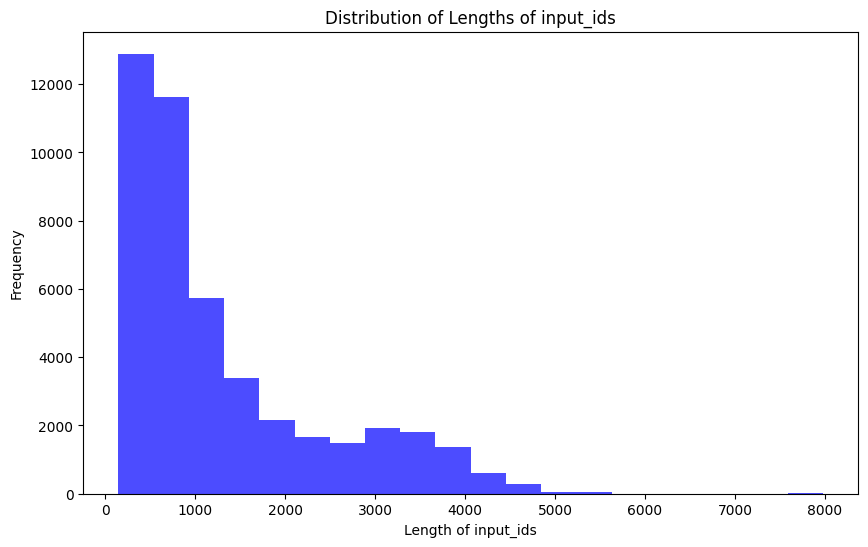

In [11]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [12]:
max_length = 4096 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [13]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/40500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [14]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

Now all the samples should be the same length, `max_length`.

45000


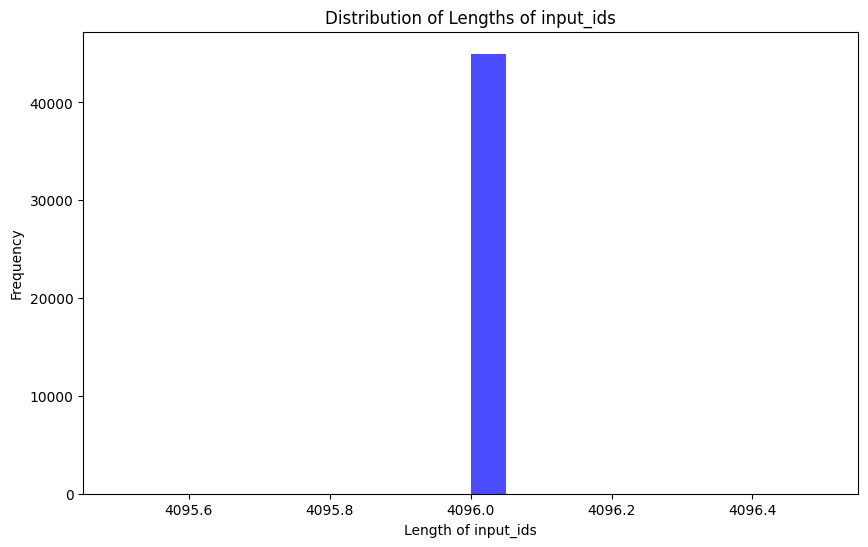

In [15]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

Optionally, you can check how Mixtral does on one of your data samples. For example, if you have a dataset of users' biometric data to their health scores, you could test the following `eval_prompt`:

In [16]:
eval_prompt = """ Given the following biometric data, score the users' health, from 0-100.

### Biometric Data:
Temperature=98.2,
Sex=F,
Age=29,
Height=69 inches,
Weight=160 lbs,
V02_Max=55,
HRV=55

### Health Score:
"""

The `eval_prompt` I used was:

In [ ]:
eval_prompt = " The following is a note by Eevee the Dog, that doesn't share anything too personal: # "

In [17]:
# Re-init the tokenizer so it doesn't add padding or eos token
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=150, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Given the following biometric data, score the users' health, from 0-100.

### Biometric Data:
Temperature=98.2,
Sex=F,
Age=29,
Height=69 inches,
Weight=160 lbs,
V02_Max=55,
HRV=55

### Health Score:
The user is in good shape and has a healthy lifestyle based on their age (29), sex(female) , height (69inches), weight (160lbs). The VO2 max of 55 indicates that they have an above average cardiovascular fitness level for someone with similar demographics to them. Their HRV value also suggests low stress levels which can be beneficial when it comes to overall wellness as high heart rate variability correlates positively with better physical performance outcomes such as endurance or strength training results due its ability help regulate autonomic nervous system activity during exercise sessions by increasing parasympathetic tone while decreasing sympathetic drive at rest periods between bouts


Observe how the model does out of the box. It doesn't talk like me.

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [18]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [19]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `w1`, `w2`, `w3`, and `lm_head`.

In [20]:
print(model)

MixtralForCausalLM(
  (model): MixtralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MixtralDecoderLayer(
        (self_attn): MixtralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (block_sparse_moe): MixtralSparseMoeBlock(
          (gate): Linear4bit(in_features=4096, out_features=8, bias=False)
          (experts): ModuleList(
            (0-7): 8 x MixtralBlockSparseTop2MLP(
              (w1): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (w2): Linear4bit(in_features=14336, out_features=4096, bias=False)
              (w3): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (act_fn): S

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [21]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "w1",
        "w2",
        "w3",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 481402880 || all params: 23964004352 || trainable%: 2.0088582564450372


See how the model looks different now, with the LoRA adapters added:

In [22]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MixtralForCausalLM(
      (model): MixtralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MixtralDecoderLayer(
            (self_attn): MixtralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_pro

### 5. Run Training!

I didn't have a lot of training samples: only about 200 total train/validation. I used 300 training steps, and I was fine with overfitting in this case. I found that the end product worked well. It took about two hours on the 4xT4.

Overfitting is when the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. In most cases, this is not desired, but since I am just playing around with a model to generate outputs like my journal entries, I was fine with a moderate amount of overfitting.

With that said, a note on training: you can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 250 steps the model starts overfitting, as described above. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-250` model repo in your output dir (`mixtral-journal-finetune`) as your final model in step 6 below.

If you're just doing something for fun like I did and are OK with overfitting, you can try different checkpoint versions with different degrees of overfitting.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [23]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [24]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [1]:
import transformers
from datetime import datetime

project = "rimworld-finetune"
base_model_name = "mixtral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=1,  # Reduced from 2 to 1
        gradient_accumulation_steps=2,  # Increased from 1 to 2
        gradient_checkpointing=True,
        max_steps=300,                  # Reduced from 500 to 300
        learning_rate=2.5e-5,
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=50,
        eval_steps=50,
        do_eval=True,
        report_to="none",  # Explicitly disable wandb
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

NameError: name 'model' is not defined

I cleared the output of the cell above because I stopped the training early, and it produced a long, ugly error message.

### 6. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`).

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base model from the Huggingface Hub:

In [29]:
from huggingface_hub import notebook_login
notebook_login()

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mixtral-8x7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mixtral-journal-finetune/checkpoint-275")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better. I like playing with the repetition penalty (just little tweaks of .01-.05 at a time). THIS IS SO FUN.

In [ ]:
eval_prompt = " The following is a note by Eevee the Dog, that doesn't share anything too personal: # "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=150, repetition_penalty=1.15)[0], skip_special_tokens=True))

### Sweet... it worked! The fine-tuned model now prints out journal entries in my style!

How funny to see it write like me as an angsty teenager, and honestly adult. I am obsessed. It knows who my friends are and talks about them, and covers the same topics I usually cover. It's really cool.

That output is quite private but I wanted you to see an example run, so I tweaked the `eval_prompt` so that it explicitly wouldn't say anything too sensitive, haha.

I hope you enjoyed this tutorial on fine-tuning Mistral's MoE ("Mixtral") on your own data. If you have any questions, feel free to reach out to me on [X](https://x.com/harperscarroll) or [Discord](https://discord.gg/RN2a436M73).

🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙